In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('./')

In [2]:
# General imports
import json
import os
from qiskit import QuantumCircuit
import numpy as np
from dataclasses import dataclass
from enum import auto, Enum

In [3]:
from component.sup_sys.algorithm_loader import load_algorithms

load_algorithms()

,Algorithm Type,Algorithm
0,ilp,MILQ_extend
1,ilp,MILQ_simple
2,ai,(none)
3,heuristic,(none)


In [38]:
from component.a_backend.fake_backend import *
from component.sup_sys.backend_loader import load_backends
print("Backend lists", load_backends())

Backend lists {'FakeAlgiers': 27, 'FakeAlmadenV2': 20, 'FakeArmonkV2': 1, 'FakeAthensV2': 5, 'FakeAuckland': 27, 'FakeBelemV2': 5, 'FakeBoeblingenV2': 20, 'FakeBogotaV2': 5, 'FakeBrisbane': 127, 'FakeBrooklynV2': 65, 'FakeBurlingtonV2': 5, 'FakeCairoV2': 27, 'FakeCambridgeV2': 28, 'FakeCasablancaV2': 7, 'FakeCusco': 127, 'FakeEssexV2': 5, 'FakeFractionalBackend': 5, 'FakeGeneva': 27, 'FakeGuadalupeV2': 16, 'FakeHanoiV2': 27, 'FakeJakartaV2': 7, 'FakeJohannesburgV2': 20, 'FakeKawasaki': 127, 'FakeKolkataV2': 27, 'FakeKyiv': 127, 'FakeKyoto': 127, 'FakeLagosV2': 7, 'FakeLimaV2': 5, 'FakeLondonV2': 5, 'FakeManhattanV2': 65, 'FakeManilaV2': 5, 'FakeMarrakesh': 156, 'FakeMelbourneV2': 15, 'FakeMontrealV2': 27, 'FakeMumbaiV2': 27, 'FakeNairobiV2': 7, 'FakeOsaka': 127, 'FakeOslo': 7, 'FakeOurenseV2': 5, 'FakeParisV2': 27, 'FakePeekskill': 27, 'FakePerth': 7, 'FakePoughkeepsieV2': 20, 'FakePrague': 33, 'FakeQuebec': 127, 'FakeQuitoV2': 5, 'FakeRochesterV2': 53, 'FakeRomeV2': 5, 'FakeSantiagoV2

Number of qubits in backend: 5
Number of qubits in backend: 5


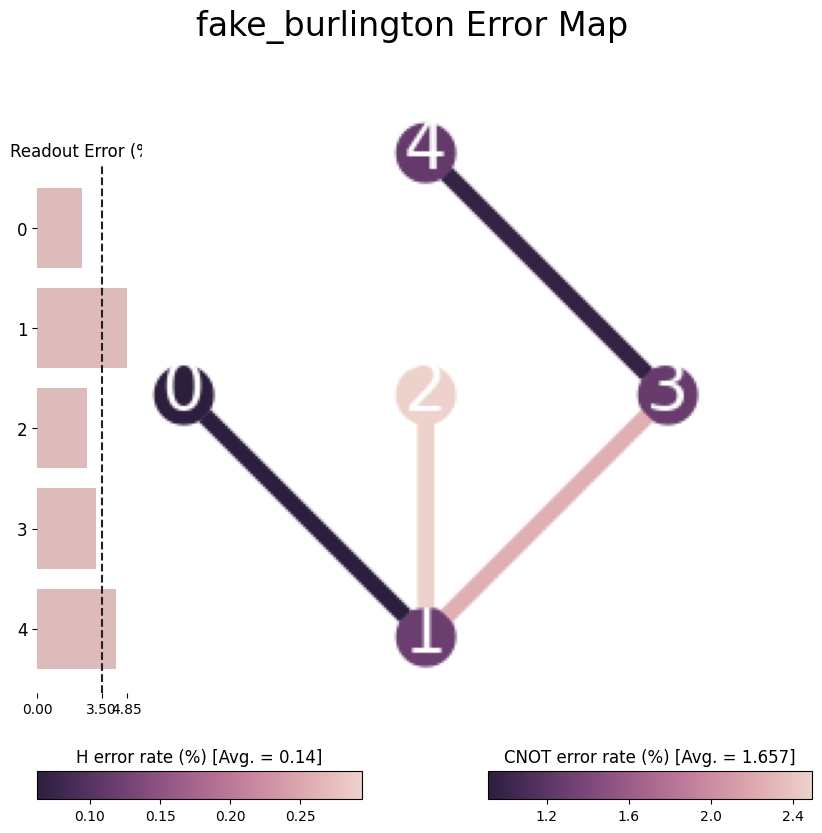

In [37]:
from component.a_backend import fake_backend
from qiskit.visualization import plot_error_map
backend0 = fake_backend.FakeBelemV2()
backend1 = fake_backend.FakeBurlingtonV2()

#print number of qubits of the backend
print("Number of qubits in backend:", backend0.num_qubits)
print("Number of qubits in backend:", backend1.num_qubits)
plot_error_map(backend0, figsize=(5,5))
plot_error_map(backend1, figsize=(10,10))

In [1]:
# 2. Number of machines
machines = {"QUITO": 5, "BELEM": 5}

Show map backend

# Generate the problem

Create benchmark

In [2]:
# 1. Number of Jobs in the batch
jobs = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5}
from component.b_benchmark.mqt_tool import benchmark_circuit

dict_circuit_jobs = {}
for job_name, num_qubits in jobs.items():
    dict_circuit_jobs[job_name] = benchmark_circuit(name_algorithm="str", circuit_size=num_qubits)

In [6]:
# Print mpl figure dict
for job_name, circuit in dict_circuit_jobs.items():
    print(f"Job: {job_name}")
    print(circuit)
    print("\n")

Job: A
        ┌───┐ ░ ┌─┐
     q: ┤ H ├─░─┤M├
        └───┘ ░ └╥┘
meas: 1/═════════╩═
                 0 


Job: B
             ┌───┐ ░ ┌─┐   
   q_0: ─────┤ X ├─░─┤M├───
        ┌───┐└─┬─┘ ░ └╥┘┌─┐
   q_1: ┤ H ├──■───░──╫─┤M├
        └───┘      ░  ║ └╥┘
meas: 2/══════════════╩══╩═
                      0  1 


Job: C
                  ┌───┐ ░ ┌─┐      
   q_0: ──────────┤ X ├─░─┤M├──────
             ┌───┐└─┬─┘ ░ └╥┘┌─┐   
   q_1: ─────┤ X ├──■───░──╫─┤M├───
        ┌───┐└─┬─┘      ░  ║ └╥┘┌─┐
   q_2: ┤ H ├──■────────░──╫──╫─┤M├
        └───┘           ░  ║  ║ └╥┘
meas: 3/═══════════════════╩══╩══╩═
                           0  1  2 


Job: D
                       ┌───┐ ░ ┌─┐         
   q_0: ───────────────┤ X ├─░─┤M├─────────
                  ┌───┐└─┬─┘ ░ └╥┘┌─┐      
   q_1: ──────────┤ X ├──■───░──╫─┤M├──────
             ┌───┐└─┬─┘      ░  ║ └╥┘┌─┐   
   q_2: ─────┤ X ├──■────────░──╫──╫─┤M├───
        ┌───┐└─┬─┘           ░  ║  ║ └╥┘┌─┐
   q_3: ┤ H ├──■─────────────░──╫──╫──

Cutting circuit

cal value from backend

In [10]:
from component.c_circuit_work.cutting.width_c import gate_to_reduce_width
from qiskit.quantum_info import SparsePauliOp

observable = SparsePauliOp(["ZZII", "IZZI", "-IIZZ", "XIXI", "ZIZZ", "IXIX"])
resultCut = gate_to_reduce_width(circuit, "AABB")
subcircuits = resultCut.subcircuits
subobservables = resultCut.subobservables
bases = resultCut.bases


from qiskit_addon_cutting import (
    cut_gates,
    partition_problem,
    generate_cutting_experiments,
    reconstruct_expectation_values,
)
from qiskit.transpiler import generate_preset_pass_manager

subexperiments, coefficients = generate_cutting_experiments(
    circuits=subcircuits, observables=subobservables, num_samples=np.inf
)

pass_manager = generate_preset_pass_manager(
    optimization_level=1, backend=backend0
)
isa_subexperiments = {
    label: pass_manager.run(partition_subexpts)
    for label, partition_subexpts in subexperiments.items()
}
from qiskit_ibm_runtime import SamplerV2, Batch
with Batch(backend=backend0) as batch:
    sampler = SamplerV2(mode=batch)
    jobs = {
        label: sampler.run(subsystem_subexpts, shots=4096 * 3)
        for label, subsystem_subexpts in isa_subexperiments.items()
    }
 
# Retrieve results
results = {label: job.result() for label, job in jobs.items()}
from qiskit_aer.primitives import EstimatorV2
# Get expectation values for each observable term
reconstructed_expval_terms = reconstruct_expectation_values(
    results,
    coefficients,
    subobservables,
)
 
# Reconstruct final expectation value
reconstructed_expval = np.dot(reconstructed_expval_terms, observable.coeffs)
 
estimator = EstimatorV2()
exact_expval = (
    estimator.run([(circuit, observable, [0.4] * len(circuit.parameters))])
    .result()[0]
    .data.evs
)
error_estimation = np.abs(reconstructed_expval - exact_expval)
relative_error_estimation = np.abs(
    (reconstructed_expval - exact_expval) / exact_expval
)

print(
    f"Reconstructed expectation value: {np.real(np.round(reconstructed_expval, 8))}"
)
print(f"Exact expectation value: {np.round(exact_expval, 8)}")
print(
    f"Error in estimation: {np.real(np.round(error_estimation, 8))}"
)
print(
    f"Relative error in estimation: {np.real(np.round(relative_error_estimation, 8))}"
)

Reconstructed expectation value: 0.92503554
Exact expectation value: 1.0
Error in estimation: 0.07496446
Relative error in estimation: 0.07496446


Apply scheduling to the benchmark circuits as require ment

In [11]:
# Setup
bigM = 1000000
timesteps = 2**5

from component.d_scheduling.algorithm.ilp.MILQ_extend import MILQ_extend_implementation
# Scheduler
MILQ_extend_implementation.example_problem(bigM, timesteps, "component/d_scheduling/algorithm/ilp/MILQ_extend/MILQ_extend_result")

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/trieu/anaconda3/envs/squan/lib/python3.10/site-packages/pulp/apis/../solverdir/cbc/linux/i64/cbc /tmp/c0bab34601d440af9c784a4b41aad3c3-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /tmp/c0bab34601d440af9c784a4b41aad3c3-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 710 COLUMNS
At line 4649 RHS
At line 5355 BOUNDS
At line 5860 ENDATA
Problem MODEL has 705 rows, 514 columns and 2929 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 9.24521 - 0.00 seconds
Cgl0002I 8 variables fixed
Cgl0003I 0 fixed, 0 tightened bounds, 493 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 394 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 202 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 176 strengthened rows, 

Saved job data to: /home/trieu/D/Quantum_Repo/Quantum_Simulation_Scheduling/component/d_scheduling/algorithm/ilp/MILQ_extend/job_data.txt
Saved job data as JSON to: /home/trieu/D/Quantum_Repo/Quantum_Simulation_Scheduling/component/d_scheduling/algorithm/ilp/MILQ_extend/job_data.json
  job  qubits machine  capacity  start   end  duration
0   A       2   QUITO         5    0.0  14.0      14.0
1   B       3   QUITO         5    0.0   8.0       8.0
2   C       5   BELEM         5    0.0  20.0      20.0
3   D       2   QUITO         5    9.0  21.0      12.0
Saved plot to: /home/trieu/D/Quantum_Repo/Quantum_Simulation_Scheduling/component/d_scheduling/algorithm/ilp/MILQ_extend/MILQ_extend_result_plot.pdf


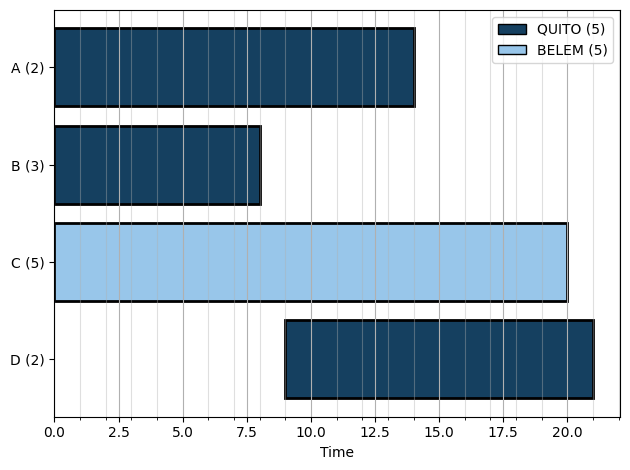

In [12]:
# Visualize
from component.d_scheduling.visualize import ilp

ilp.visualize("component/d_scheduling/algorithm/ilp/MILQ_extend/MILQ_extend_result.json")


In [15]:
from component.d_scheduling.analyze import analyze_cal

data = analyze_cal.load_job_data("component/d_scheduling/algorithm/ilp/MILQ_extend/job_data.txt")
metrics = analyze_cal.calculate_metrics(data)
analyze_cal.print_metrics(metrics)


=== Metrics ===
Waiting Time: 9.0
Response Time: 63.0
Makespan: 21.0
Throughput: 0.1905
Utilization on machine QUITO: 0.7238
Utilization on machine BELEM: 0.9524
Average Utilization: 0.8381


Transpile the circuit with pass_manager

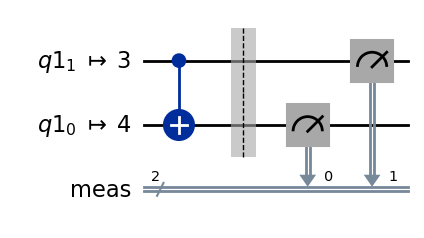

In [16]:
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.transpiler import generate_preset_pass_manager

subcircuits['A'].data = [hasChange for hasChange in subcircuits['A'].data if hasChange.operation.name != "qpd_1q"]
subcircuits['A'].measure_all()

target = backend0.target
coupling_map = target.build_coupling_map()
pass_manager = generate_preset_pass_manager(
    optimization_level=3, coupling_map=coupling_map, seed_transpiler=12345
)
qc_t_cm_lv0 = pass_manager.run(subcircuits['A'])
qc_t_cm_lv0.draw("mpl", idle_wires=False, fold=-1)
 

In [17]:
from component.e_mapping.transpile import transpile_circuit_pass

qc_t_cm_lv1 = transpile_circuit_pass(subcircuits['A'], backend0)


In [18]:
from component.e_mapping.transpile import transpile_circuit_trans

qc_t_trans  = transpile_circuit_trans(subcircuits['A'], backend0)

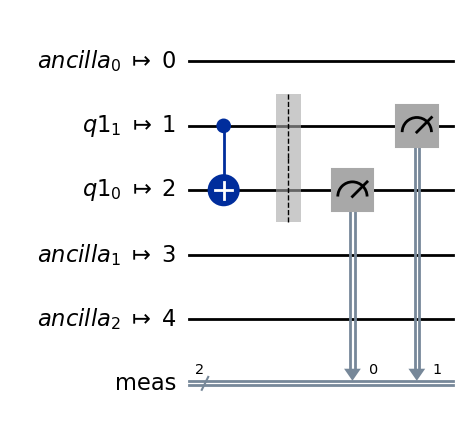

In [19]:
qc_t_trans.draw("mpl")

Transpile the circuit with transpile only

Plot transpiled circuit in backend

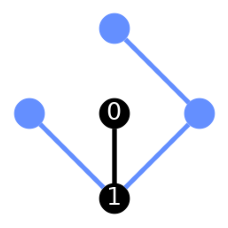

In [20]:
# after have the circuit we connect to
from qiskit.visualization import plot_circuit_layout
plot_circuit_layout(qc_t_trans, backend0)

assemble the circuit to have the output in backend and ideal

{'00': 1024}


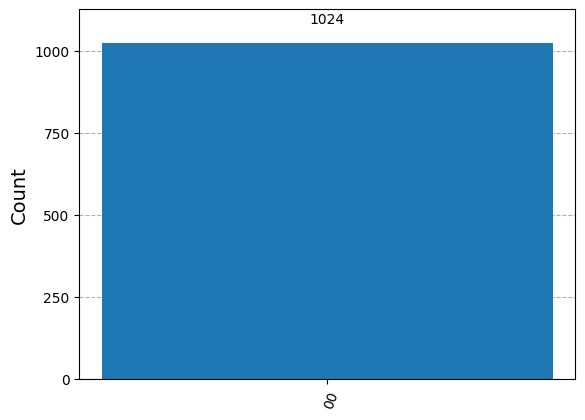

In [21]:
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, plot_state_city
import qiskit.quantum_info as qi
from qiskit import transpile


simulator_ideal = AerSimulator()
resultideal = simulator_ideal.run(subcircuits['A']).result()
counts_ideal = resultideal.get_counts(subcircuits['A'])
print(counts_ideal)
plot_histogram(counts_ideal)

reconstruct the circuit

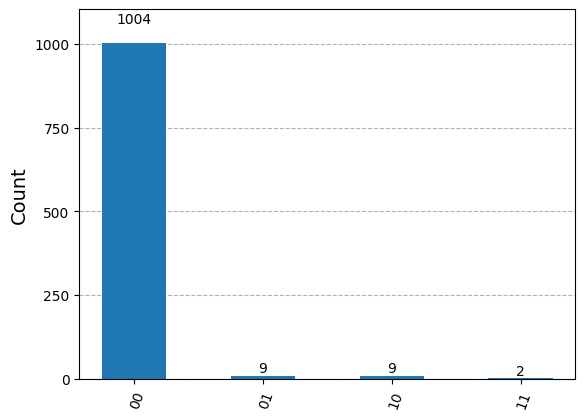

In [27]:
from qiskit_ibm_runtime import SamplerV2

samplerbackend = SamplerV2(backend0)
job = samplerbackend.run([qc_t_cm_lv1])
result_sim = job.result()[0]
counts_sim = result_sim.data.meas.get_counts()
plot_histogram(counts_sim)

In [28]:
from component.f_assemble.assemble_work import fidelity_from_counts

fidelity_val, rho_ideal, rho_sim = fidelity_from_counts(counts_ideal, counts_sim)
print("\nIdeal Density Matrix:")
print(rho_ideal)

print("\nSimulated Density Matrix:")
print(rho_sim)

print("\nFidelity:", fidelity_val)


Ideal Density Matrix:
DensityMatrix([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
               [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
               [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
               [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j]],
              dims=(2, 2))

Simulated Density Matrix:
DensityMatrix([[0.98046875+0.j, 0.        +0.j, 0.        +0.j,
                0.        +0.j],
               [0.        +0.j, 0.00878906+0.j, 0.        +0.j,
                0.        +0.j],
               [0.        +0.j, 0.        +0.j, 0.00878906+0.j,
                0.        +0.j],
               [0.        +0.j, 0.        +0.j, 0.        +0.j,
                0.00195312+0.j]],
              dims=(2, 2))

Fidelity: 0.98046875


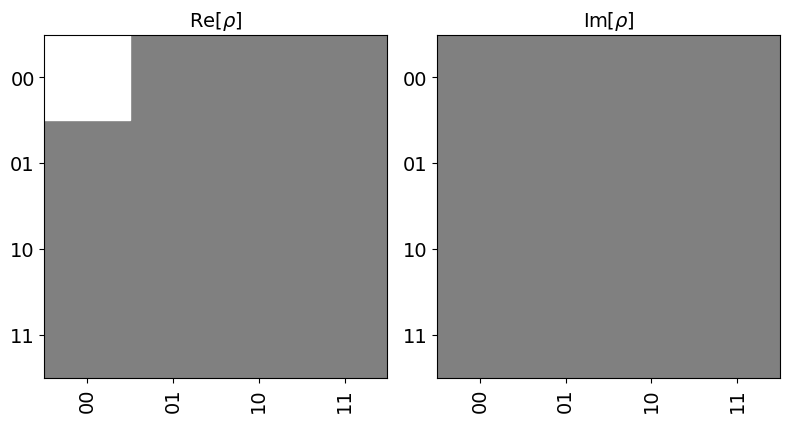

In [29]:
rho_ideal.draw(output='hinton')

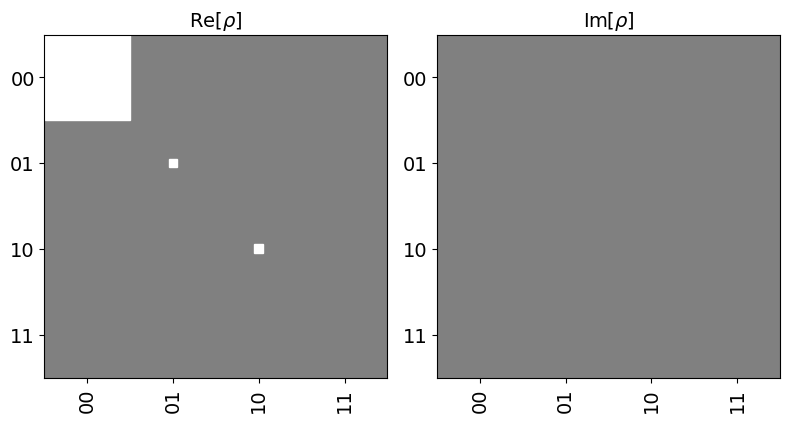

In [21]:
rho_sim.draw(output='hinton')